In [67]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from sklearn.linear_model import Perceptron
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.model_selection import cross_val_score,cross_val_predict
import torch
import torch.nn as nn
import os
import seaborn as sns

IMPORTAZIONE DEI DATI DA FILE CSV

In [68]:

def import_data():

    try:
        data = pd.read_csv(
            filepath_or_buffer='../Default_of_credit_card_clients/assets/default_of_credit_card_clients.csv'
        )
        
        return data

    except Exception as e:
        print(f'Errore in utils/import_data: {str(e)}')
        
data = import_data()

INFORMAZIONI SUL DATASET

1. Genere

Text(0.5, 1.0, 'Gender distribution')

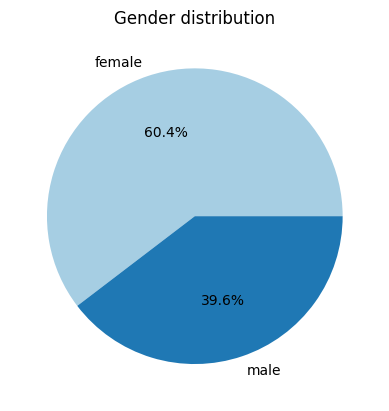

In [69]:
sex_col = data.loc[:, 'SEX']
sex_counts = sex_col.value_counts(normalize=True) * 100

colors = plt.cm.Paired(range(len(sex_counts)))

plt.pie(sex_counts, labels=["female","male"], autopct='%1.1f%%', colors=colors)
plt.title("Gender distribution")

2. livello di istruzione per genere

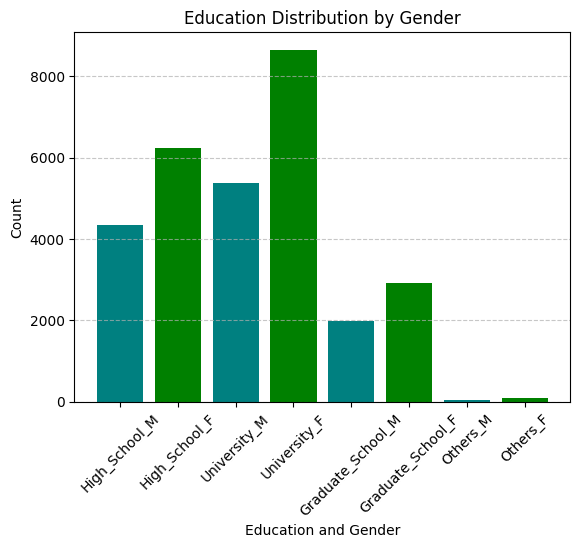

In [70]:
education_sex_counts = data.groupby(['EDUCATION', 'SEX']).size().unstack()

male_counts = education_sex_counts[1].fillna(0)
female_counts = education_sex_counts[2].fillna(0)

plt.bar(
    [
        "High_School_M", 
        "High_School_F",
        "University_M", 
        "University_F",
        "Graduate_School_M", 
        "Graduate_School_F",
        "Others_M",
        "Others_F"
    ],
    [
        male_counts[1], 
        female_counts[1],
        male_counts[2], 
        female_counts[2],
        male_counts[3], 
        female_counts[3],
        male_counts[4],
        female_counts[4]
    ],
    color=['#008080', '#008000'] * 4,
)

plt.title("Education Distribution by Gender")
plt.xlabel("Education and Gender")
plt.ylabel("Count")
plt.tick_params(axis='x', rotation=45) 
plt.grid(axis='y', linestyle='--', alpha=0.7) 

3. Informazioni sullo stato dei conti correnti


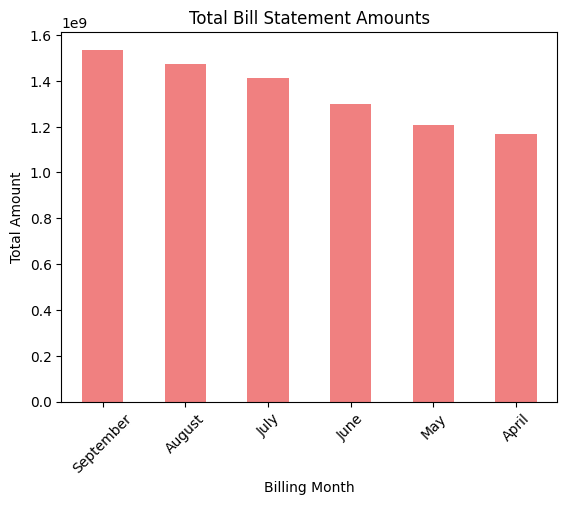

In [71]:
bill_state_columns = data.loc[:, 'BILL_AMT1':'BILL_AMT6']
bill_state_sums = bill_state_columns.sum()

custom_labels = ["September","August","July","June","May","April"]
bill_state_sums.plot(kind='bar',color='lightcoral')
plt.title("Total Bill Statement Amounts")
plt.xlabel("Billing Month")
plt.ylabel("Total Amount")
plt.xticks(range(len(custom_labels)), custom_labels, rotation=45)
plt.show()

4. informazioni sul totale degli importi pagamento

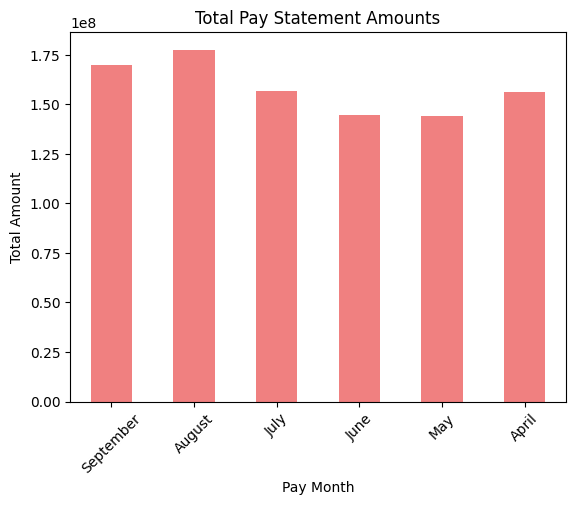

In [72]:
pay_state_columns = data.loc[:, 'PAY_AMT1':'PAY_AMT6']

pay_state_sums = pay_state_columns.sum()
custom_labels = ["September", "August", "July", "June", "May", "April"]
pay_state_sums.plot(kind='bar',color='lightcoral')
plt.title("Total Pay Statement Amounts")
plt.xlabel("Pay Month")
plt.ylabel("Total Amount")
plt.xticks(range(len(custom_labels)), custom_labels, rotation=45)
plt.tick_params(axis='x', rotation=45)

5. Informazioni sulla storia dei pagamenti 

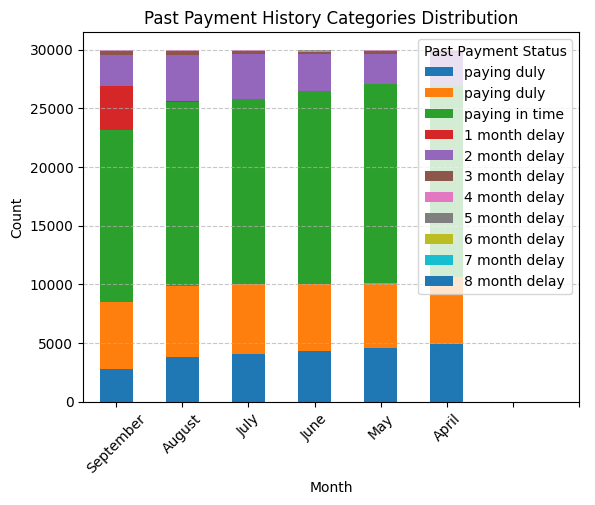

In [73]:
payment_history_columns = data.loc[:, 'PAY_0':'PAY_6']
payment_history_counts = payment_history_columns.apply(lambda col: col.value_counts()).T

custom_labels = ["September", "August", "July", "June", "May", "April",' ',' ']
custom_labels_legend = [
    'paying duly',
    'paying duly',
    'paying in time',
    '1 month delay',
    '2 month delay',
    '3 month delay',
    '4 month delay',
    '5 month delay',
    '6 month delay',
    '7 month delay',
    '8 month delay',
    '9 month or above delay',

]

payment_history_counts.plot(kind='bar', stacked=True,xticks=range(len(custom_labels)))
plt.title("Past Payment History Categories Distribution")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(custom_labels_legend,title="Past Payment Status", loc='upper right')
plt.xticks(range(len(custom_labels)), custom_labels, rotation=45)
plt.tick_params(axis='x', rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

6. Percentuale di clienti in ritardo con i pagamenti

Text(0.5, 1.0, 'Percentage of Paid and Unpaid Customers')

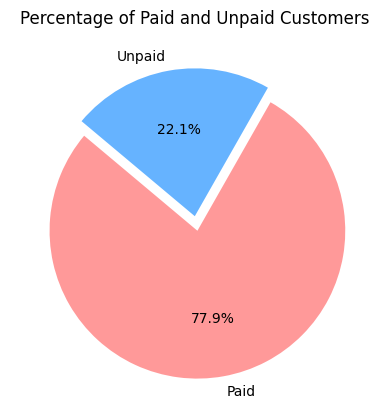

In [74]:
num_paid = data[data['default payment next month'] == 0].shape[0]
num_unpaid = data[data['default payment next month'] == 1].shape[0]

total = num_paid + num_unpaid
percent_paid = (num_paid / total) * 100
percent_unpaid = (num_unpaid / total) * 100

labels = ['Paid', 'Unpaid']
sizes = [percent_paid, percent_unpaid]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Paid and Unpaid Customers')

CORRELAZIONE 

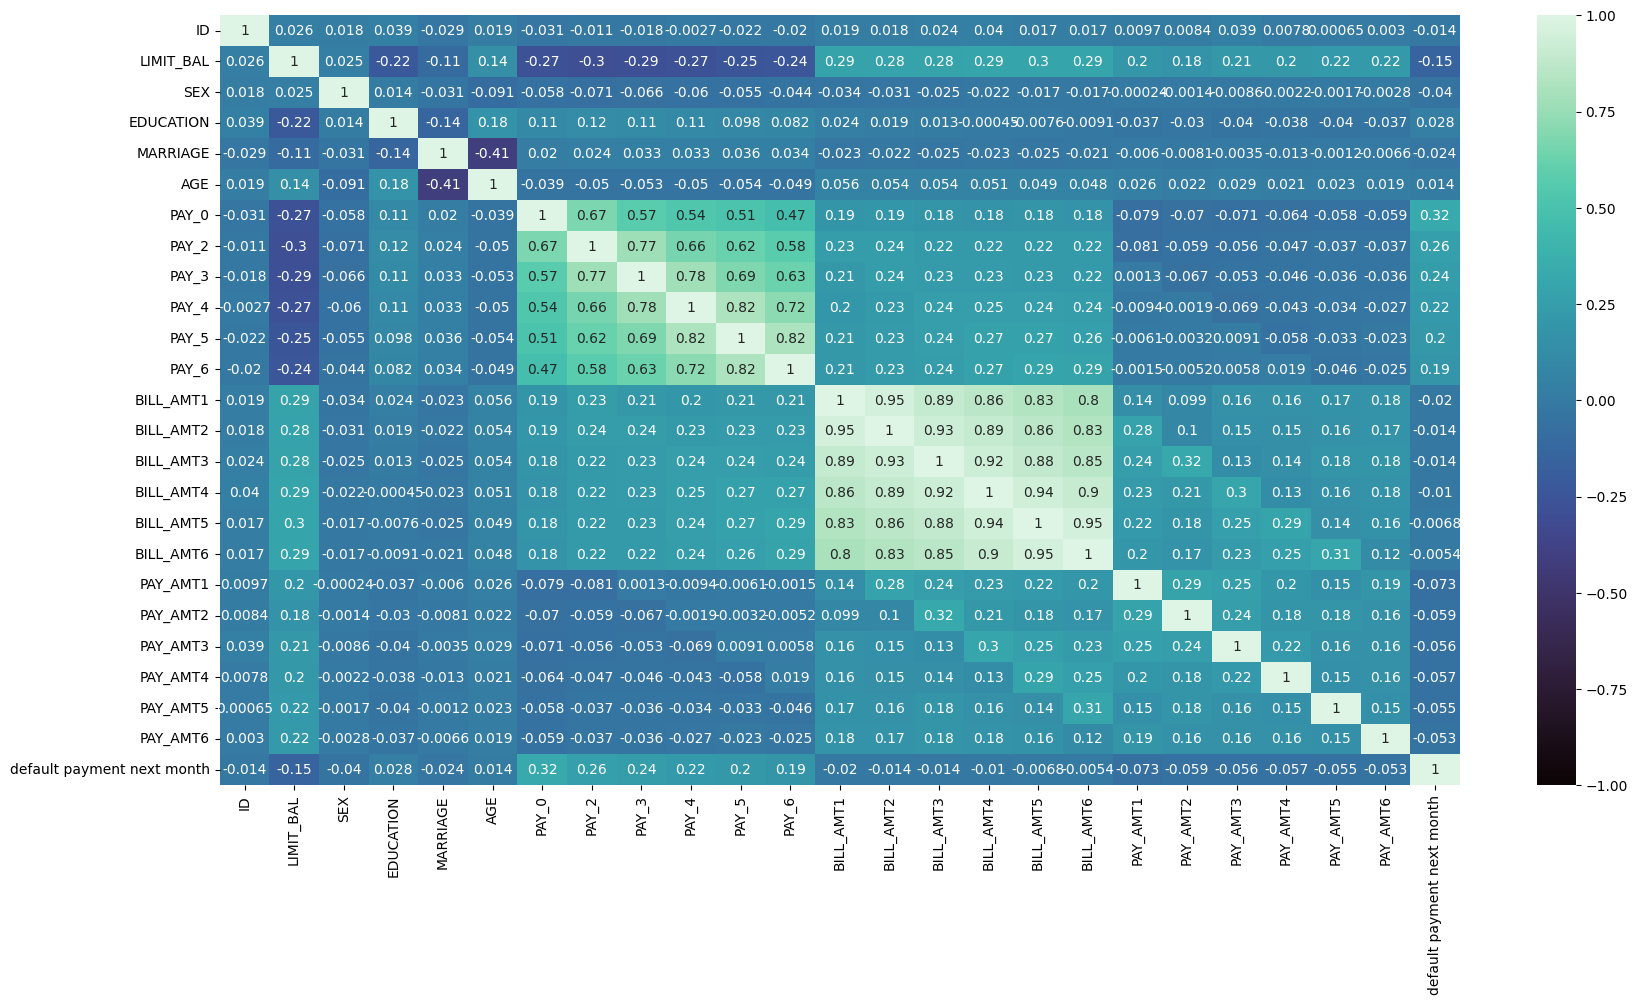

In [75]:
def show_heatmap(df):

    correlation = df.corr()

    plt.figure(figsize=(20,10))
    sns.heatmap(correlation,annot=True,vmin=-1,cmap='mako')
    plt.show()
    
show_heatmap(data)

FASE DI PRE PROCESSING


In [76]:
def one_hot_encoding(df,dict):

    df = df.copy()

    for column, prefix in dict.items():

        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df,dummies],axis=1)
        df = df.drop(column,axis=1)

    return df 

def preprocessing(df):

    df = df.copy()

    #drop ID column 
    df =df.drop('ID',axis=1)

    #hot encoding
    dict = {
        'EDUCATION' : 'EDU',
        'MARRIAGE' : 'MAR'
    }
    
    df = one_hot_encoding(df,dict)

    y = df['default payment next month'].copy()
    X = df.drop('default payment next month',axis=1).copy()

    #scaling
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X),columns= X.columns)


    return X, y

X,y = preprocessing(data)

SPLIT

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

MODELLI

1. Percettrone a singolo strato

----------Percettrone-------------------
Epoch 100/500, Loss: 0.41579166666666667
Epoch 200/500, Loss: 0.3995
Epoch 300/500, Loss: 0.35833333333333334
Epoch 400/500, Loss: 0.3864166666666667
Epoch 500/500, Loss: 0.3474583333333333


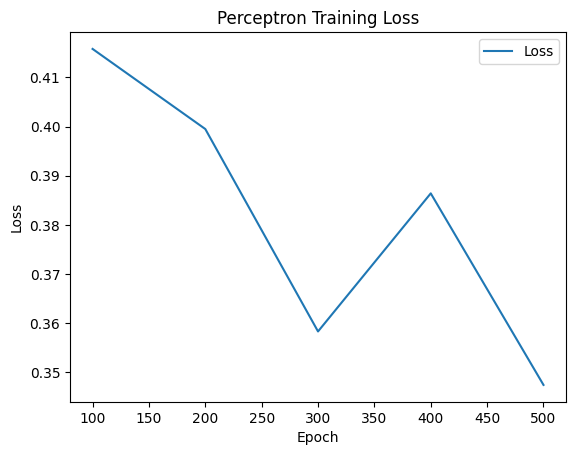

-------------------------------------------------
Train metrics
    accuracy  precision     recall         f1                    conf_matrix
0  58.420833  21.089959  31.789197  25.357170  [[12326, 6342], [3637, 1695]]
1  60.050000  22.226573  31.939235  26.212098  [[12709, 5959], [3629, 1703]]
2  64.166667  24.380684  29.163541  26.558497  [[13845, 4823], [3777, 1555]]
3  61.358333  24.355972  35.108777  28.760178  [[12854, 5814], [3460, 1872]]
4  65.254167  25.691188  29.801200  27.593991  [[14072, 4596], [3743, 1589]]
--------------------------------------------------
Test metrics
accuracy: 66.63333333333334
precision: 26.639892904953143
Recall: 30.52147239263804
F1-Score: 28.448892065761257
confusion matrix:
[[3600 1096]
 [ 906  398]]


In [78]:
def perceptron(X_train, X_test, y_train, y_test,X,y):

    print("----------Percettrone-------------------")

    losses=[]
    train_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'conf_matrix': []
    }

    epochs = 500
    lr = 0.03

    #Model
    perceptron = Perceptron(
        max_iter=epochs,
        eta0=lr,
        random_state=42
    )

    #Training phase    

    for epoch in range(epochs):

        perceptron.partial_fit(X_train,y_train,classes=np.unique(y_train))
        y_pred_train = perceptron.predict(X_train)

        if (epoch +1 )%100==0:

            loss = np.mean(y_pred_train != y_train)
            losses.append(loss)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss}')

            train_accuracy = accuracy_score(y_train, y_pred_train) *100
            train_precision = precision_score(y_train, y_pred_train) *100
            train_recall = recall_score(y_train, y_pred_train) *100
            train_f1 = f1_score(y_train, y_pred_train) *100
            train_conf_matrix = confusion_matrix(y_train, y_pred_train)

            train_metrics['accuracy'].append(train_accuracy)
            train_metrics['precision'].append(train_precision)
            train_metrics['recall'].append(train_recall)
            train_metrics['f1'].append(train_f1)
            train_metrics['conf_matrix'].append(train_conf_matrix)

    plt.plot(range(100, epochs + 1, 100), losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Perceptron Training Loss')
    plt.legend()
    plt.show()

    
    train_metrics = pd.DataFrame(train_metrics)
    print("-------------------------------------------------")
    print("Train metrics")
    print(train_metrics)

    #Test phase
    y_pred_test = perceptron.predict(X_test)
    
    #Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred_test) *100
    precision = precision_score(y_test, y_pred_test) *100
    recall = recall_score(y_test, y_pred_test) *100
    f1 = f1_score(y_test, y_pred_test) * 100
    conf_matrix = confusion_matrix(y_test, y_pred_test) 

    print("--------------------------------------------------")
    print("Test metrics")
    print(f"accuracy: {accuracy}")
    print(f"precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("confusion matrix:")
    print(conf_matrix)
    
perceptron(X_train, X_test, y_train, y_test,X,y)


2. Albero decisionale

------------------Decision Tree-----------------------
------------------------------------------------------------------------------
Criterion: gini
Splitter: best
Fold number: 10
------------------------------------------------------------------------------
Metriche di cross validation
   Profondità  Accuratezza  Precisione    Recall  F1-Score  \
0           3     0.820208    0.674084  0.369280  0.477160   
1           5     0.818667    0.672657  0.358027  0.467319   
2           7     0.815167    0.649134  0.365716  0.467850   
3          10     0.810542    0.624248  0.369842  0.464492   

                Confusion Matrix  
0   [[17716, 952], [3363, 1969]]  
1   [[17739, 929], [3423, 1909]]  
2  [[17614, 1054], [3382, 1950]]  
3  [[17481, 1187], [3360, 1972]]  
------------------------------------------------------------------------------
Metriche sul training set:
   Profondità  Accuratezza  Precisione    Recall  F1-Score  \
0           5     0.823958    0.693059  0.372656  0.48469

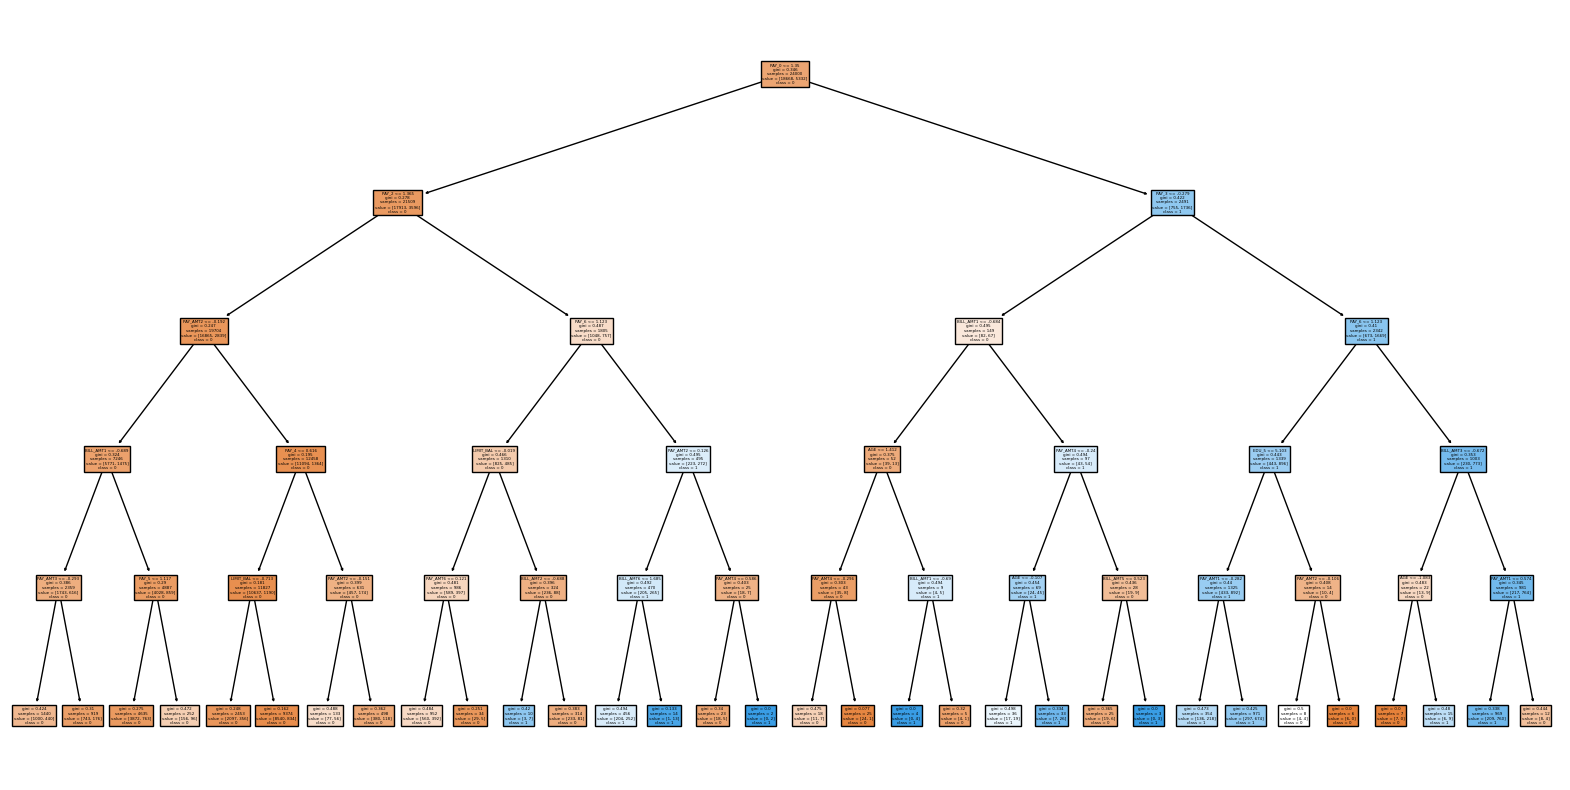

In [79]:

class DecisionTree:

    def __init__(self,criterion,split_criterion,depths_to_test,fold_number,X_train,X_test,y_train,y_test):

        self.criterion = criterion
        self.splitter = split_criterion
        self.depths_to_test=depths_to_test
        self.fold_number=fold_number
        self.X_train=X_train
        self.X_test=X_test
        self.y_train=y_train
        self.y_test=y_test

        #------cv metrics-----#

        self.cv_accuracies = {}
        self.cv_precisions = {}
        self.cv_recalls = {}
        self.cv_f1_scores = {}
        self.cv_conf_matrices = {}

    def create_model(self,max_depth):

        return tree.DecisionTreeClassifier(
            criterion=self.criterion,
            splitter=self.splitter,
            max_depth=max_depth
        )


    def execute_k_fold_cross_validation(self):

        for depth in self.depths_to_test:

            dt = self.create_model(max_depth=depth)

            y_pred = cross_val_predict(dt,self.X_train,self.y_train,cv=self.fold_number)

            accuracy = accuracy_score(self.y_train,y_pred)
            self.set_cv_accuracies(depth,accuracy)

            precision = precision_score(self.y_train, y_pred)
            self.set_cv_precisions(depth,precision)
            
            recall = recall_score(self.y_train, y_pred)
            self.set_cv_recalls(depth,recall)
            
            f1 = f1_score(self.y_train, y_pred)
            self.set_cv_f1_scores(depth,f1)
            
            conf_matrix = confusion_matrix(self.y_train, y_pred)
            self.set_cv_conf_matrices(depth,conf_matrix)

    #---------------------GETTER--------------------------------#

    def get_cv_metrics(self):

        return pd.DataFrame({
            'Profondità': self.depths_to_test,
            'Accuratezza': [self.cv_accuracies[depth] for depth in self.depths_to_test],
            'Precisione': [self.cv_precisions[depth] for depth in self.depths_to_test],
            'Recall': [self.cv_recalls[depth] for depth in self.depths_to_test],
            'F1-Score': [self.cv_f1_scores[depth] for depth in self.depths_to_test],
            'Confusion Matrix': [self.cv_conf_matrices[depth] for depth in self.depths_to_test],
        })
    
   
    
    #------------------------SETTER-------------------------------#
    
    def set_cv_accuracies(self,depth,accuracy):

        if depth is not None and accuracy is not None:

            self.cv_accuracies[depth] = accuracy

    def set_cv_precisions(self,depth,precision):

        if depth is not None and precision is not None:

            self.cv_precisions[depth] = precision

    def set_cv_recalls(self,depth,recall):

        if depth is not None and recall is not None:

            self.cv_recalls[depth] = recall

    def set_cv_f1_scores(self,depth,f1_score):

        if depth is not None and f1_score is not None:

            self.cv_f1_scores[depth] = f1_score

    def set_cv_conf_matrices(self,depth,conf_matrix):

        if depth is not None and conf_matrix is not None:

            self.cv_conf_matrices[depth] = conf_matrix


def decision_tree(X_train, X_test, y_train, y_test):

    print("------------------Decision Tree-----------------------")

    depths_to_test = [3,5,7,10]
    criterion="gini"
    splitter="best"
    fold_number=10

    dt_agent = DecisionTree(
        criterion=criterion,
        split_criterion=splitter,
        depths_to_test=depths_to_test,
        fold_number=fold_number,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    )    
    
    dt_agent.execute_k_fold_cross_validation()
    cv_metrics = dt_agent.get_cv_metrics()
    
    #create the new model based on the best depth 

    best_depth=5

    best_dt = DecisionTreeClassifier(
        criterion=criterion,
        splitter=splitter,
        max_depth=best_depth
    )

    #train the new model
    best_dt.fit(X_train,y_train)
    y_train_pred = best_dt.predict(X_train)

    #test the new model
    y_pred = best_dt.predict(X_test)

    
    #get train and test metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)

    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_conf_matrix = confusion_matrix(y_test, y_pred)

    print("------------------------------------------------------------------------------")

    print("Criterion: " + str(criterion))
    print("Splitter: "+ str(splitter))
    print("Fold number: "+ str(fold_number))

    print("------------------------------------------------------------------------------")
    print("Metriche di cross validation")
    print(cv_metrics)

    print("------------------------------------------------------------------------------")
    print("Metriche sul training set:")
    train_metrics = pd.DataFrame({
        'Profondità': best_depth,
        'Accuratezza': [train_accuracy],
        'Precisione': [train_precision],
        'Recall': [train_recall],
        'F1-Score': [train_f1],
        'Confusion Matrix': [train_conf_matrix],
    })
    
    print(train_metrics)

    print("------------------------------------------------------------------------------")
    print("Metriche sul test set:")
    test_metrics  =pd.DataFrame({
        'Profondità': best_depth,
        'Accuratezza': [test_accuracy],
        'Precisione': [test_precision],
        'Recall': [test_recall],
        'F1-Score': [test_f1],
        'Confusion Matrix': [test_conf_matrix],
    })
    print(test_metrics)

    plt.figure(figsize=(20, 10))
    plot_tree(best_dt, feature_names=X_train.columns, class_names=[str(cls) for cls in y_train.unique()], filled=True)
    plt.show()
    
decision_tree(X_train, X_test, y_train, y_test)

3. Rete neurale profonda

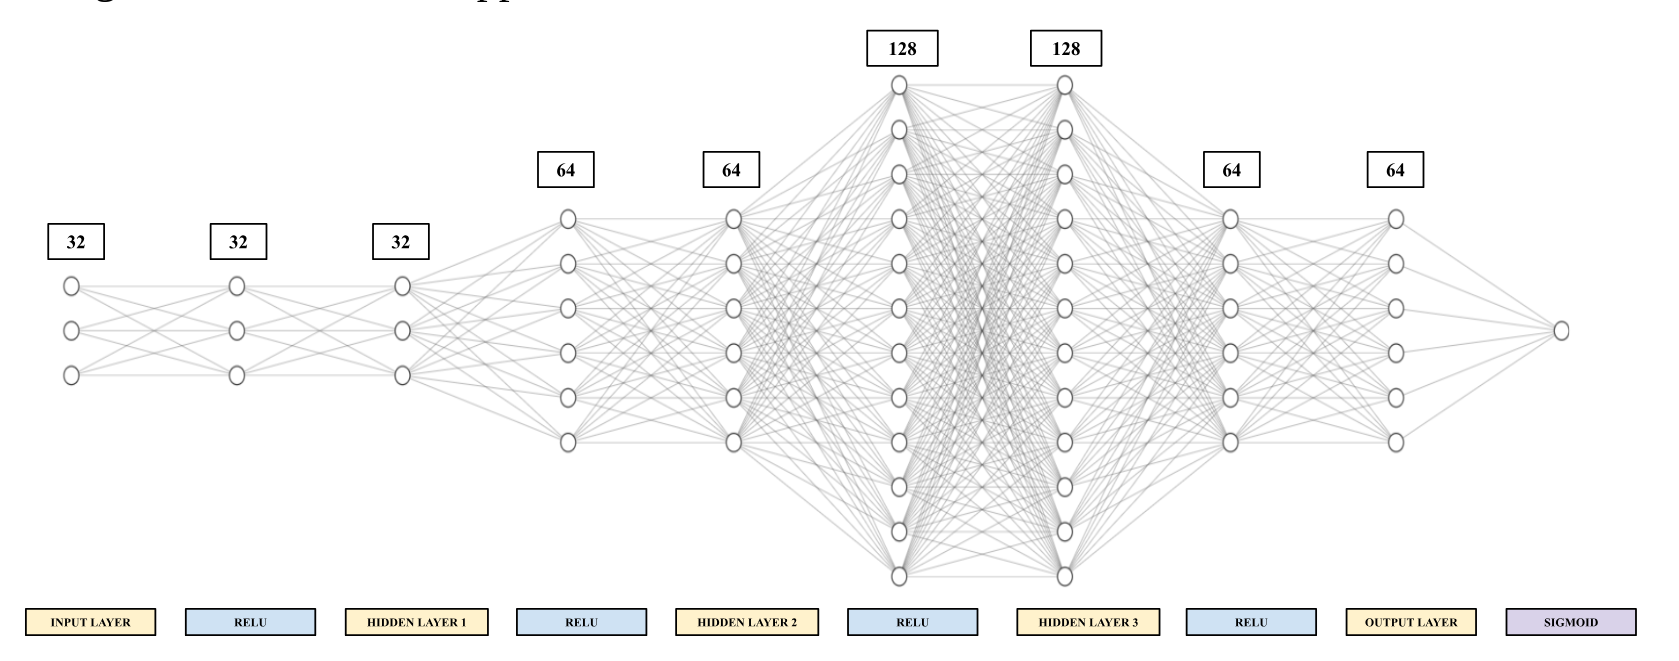

----------------Deep Neural Network----------------------
Epoch = 0 - Loss = 0.6983422636985779 
Epoch = 100 - Loss = 0.44151079654693604 
-------------------------------------------------
Train metrics
   accuracy  precision    recall        f1                        matrix
0  0.822417   0.677152  0.383533  0.489703  [[17693, 975], [3287, 2045]]
--------------------------------------------------
Test metrics
   accuracy  precision    recall        f1                     matrix
0      0.82   0.641414  0.389571  0.484733  [[4412, 284], [796, 508]]


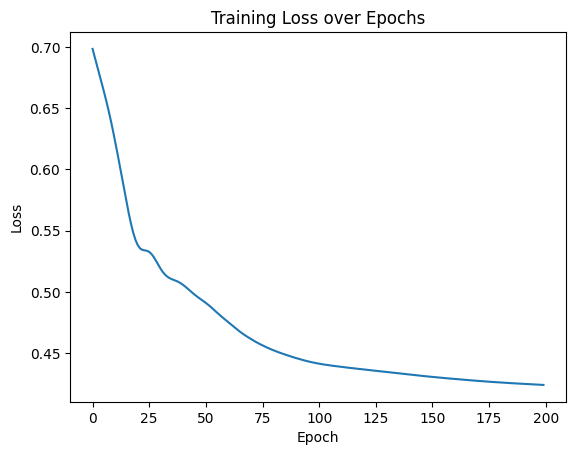

In [80]:
class DeepNeuralNetwork(nn.Module):

    def __init__(self,input_size,hidden_sizes,output_size,lr,epochs,weight_decay):

        super().__init__()

        self.input_size=input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.lr = lr
        self.epochs = epochs
        self.weight_decay = weight_decay

        self.model = self.build_model()

        self.criterion = None
        self.optimizer = None

        self.losses = []
        self.y_train_preds = []
        self.y_test_preds = []

    def build_model(self):

        layers = []
        prev_layer_size = self.input_size

        for hidden_size in self.hidden_sizes:

            layers.append(nn.Linear(prev_layer_size,hidden_size))
            layers.append(nn.ReLU())
            
            prev_layer_size = hidden_size

        layers.append(nn.Linear(prev_layer_size,self.output_size))
        layers.append(nn.Sigmoid())

        return nn.Sequential(*layers)



    def forward(self,x):

        return self.model(x)

    def training_phase(self,X_train,y_train):

        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(self.parameters(),lr=self.lr,weight_decay=self.weight_decay)

        for epoch in range(self.epochs):

            optimizer.zero_grad()
            y_pred = self(X_train)
            loss = criterion(y_pred,y_train.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            if epoch % 100 == 0:
                print(f"Epoch = {epoch} - Loss = {loss.item()} ")

            self.losses.append(loss.item())
            if epoch == self.epochs-1:
                self.y_train_preds.append(y_pred)

        self.criterion = criterion
        self.optimizer = optimizer


    def test_phase(self,X_test,y_test):

        with torch.no_grad():

            y_pred = self(X_test)
            self.y_test_preds.append(y_pred)

            
    def plot_loss_fn(self):

        plt.plot(self.losses, label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss over Epochs")
        plt.show()

    def get_eval_metrics(self,y,y_pred):
        
        y_pred = torch.cat(y_pred,dim=0).detach().numpy().flatten()
        y_pred = (y_pred >= 0.5).astype(float)
        y = np.array(y).flatten()
        

        accuracy = accuracy_score(y,y_pred) 
        precision = precision_score(y,y_pred)    
        recall = recall_score(y,y_pred)   
        f1 = f1_score(y,y_pred)
        matrix =confusion_matrix(y, y_pred)

        return pd.DataFrame({
            'accuracy': [accuracy],
            'precision': [precision],
            'recall': [recall],
            'f1': [f1],
            'matrix': [matrix]  
        })

    def save_model(self,model,train_metrics):

        dir = '../pytorch_venv/Default_of_credit_card_clients/saved_model'

        if not os.path.exists(dir):
            os.makedirs(dir)

        existing_models = [file for file in os.listdir(dir) if "dnn" in file]
        count = len(existing_models)

        new_model_name = f"dnn_{count+1}.pth"

        torch.save(

            {
                'model_state_dict': model.state_dict(),
                'epochs' : self.epochs,
                'lr' : self.lr,
                'optimizer': self.optimizer.state_dict(),
                'criterion': self.criterion,
                'weight_decay': self.weight_decay,
                'structure':{

                    'n_neuron_input_layer':self.input_size,
                    'n_neuron_hidden_layers': self.hidden_sizes,
                    'out':1
                },
                'train_metrics': train_metrics,
                'losses' :self.losses,
            },
            os.path.join(dir,new_model_name)
        )

def get_tensors(X_train,X_test,y_train,y_test):

    X_train_tensor = torch.tensor(X_train.values,dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test.values,dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values,dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values,dtype=torch.float32)

    return X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor

def deep_neural_network(X_train,X_test,y_train,y_test):

    print("----------------Deep Neural Network----------------------")

    X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor = get_tensors(X_train,X_test,y_train,y_test)

    #best
    input_size = X_train.shape[1] 
    hidden_sizes = [32,64,128,64]
    output_size = 1

    epochs = 200
    lr = 0.001
    weight_decay = 0.002

    epochs = 200
    lr = 0.001
    weight_decay = 0.001

    dnn = DeepNeuralNetwork(
        input_size=input_size,
        hidden_sizes = hidden_sizes,
        output_size=output_size,
        lr=lr,
        epochs=epochs,
        weight_decay = weight_decay
    )

    dnn.training_phase(X_train_tensor,y_train_tensor)

    dnn.test_phase(X_test_tensor,y_test_tensor)

    train_metrics = dnn.get_eval_metrics(y_train,dnn.y_train_preds)
    test_metrics = dnn.get_eval_metrics(y_test,dnn.y_test_preds)

    print("-------------------------------------------------")
    print("Train metrics")
    print(train_metrics)

    print("--------------------------------------------------")
    print("Test metrics")
    print(test_metrics)

    dnn.plot_loss_fn()

    dnn.save_model(
        dnn,
        train_metrics    
    )
    
deep_neural_network(X_train,X_test,y_train,y_test)

3.1 Confronto tra le reti neurali

In [81]:
def test_models(X_train, X_test, y_train, y_test):

    X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = get_tensors(X_train, X_test, y_train, y_test)
    dir = '../pytorch_venv/Default_of_credit_card_clients/saved_model'

    for file in os.listdir(dir):
        if file.endswith(".pth"):
            params = torch.load(os.path.join(dir, file))

            deep_neural_network = DeepNeuralNetwork(
                input_size=params['structure']['n_neuron_input_layer'],
                hidden_sizes=params['structure']['n_neuron_hidden_layers'],
                output_size=params['structure']['out'],
                lr=params['lr'],
                epochs=params['epochs'],
                weight_decay=params['weight_decay']
            )

            deep_neural_network.load_state_dict(params['model_state_dict'])

            deep_neural_network.test_phase(X_test_tensor, y_test_tensor)

            test_metrics = deep_neural_network.get_eval_metrics(
                y_test, 
                deep_neural_network.y_test_preds
            )

            print('---------------------------------------------------------------------------------')
            print(
                f"rete:  {file}\n"
                f"n_layer:  {len(list(deep_neural_network.parameters()))}\n"
                f"n_neuron_per_layer:  {[layer.size()[0] for layer in deep_neural_network.parameters()]}\n"
                f"epochs:  {params.get('epochs', 'N/D')}\n"
                f"lr:  {params.get('lr', 'N/D')}\n"
                f"weight_decay:  {params.get('weight_decay','N/D')}\n"
                
            )

            print('#####train_metrics#####')
            print(params['train_metrics'])

            print('#####test_metrics#####')
            print(test_metrics)

            #visualizzo la rete 
            
            '''dot = make_dot(deep_neural_network(X_test_tensor))
            dot.render(f"{file}", format="png")'''

test_models(X_train, X_test, y_train, y_test)

---------------------------------------------------------------------------------
rete:  dnn_9.pth
n_layer:  10
n_neuron_per_layer:  [32, 32, 64, 64, 128, 128, 64, 64, 1, 1]
epochs:  200
lr:  0.001
weight_decay:  0.01

#####train_metrics#####
   accuracy  precision    recall        f1                        matrix
0  0.816333   0.666068  0.347524  0.456741  [[17739, 929], [3479, 1853]]
#####test_metrics#####
   accuracy  precision   recall      f1                     matrix
0  0.817167   0.646393  0.35046  0.4545  [[4446, 250], [847, 457]]


---------------------------------------------------------------------------------
rete:  dnn_23.pth
n_layer:  14
n_neuron_per_layer:  [32, 32, 64, 64, 128, 128, 64, 64, 32, 32, 16, 16, 1, 1]
epochs:  200
lr:  0.001
weight_decay:  0.001

#####train_metrics#####
   accuracy  precision    recall        f1                         matrix
0  0.820042   0.656763  0.397974  0.495621  [[17559, 1109], [3210, 2122]]
#####test_metrics#####
   accuracy  precision    recall        f1                     matrix
0     0.819   0.633578  0.396472  0.487736  [[4397, 299], [787, 517]]
---------------------------------------------------------------------------------
rete:  dnn_2.pth
n_layer:  10
n_neuron_per_layer:  [32, 32, 64, 64, 128, 128, 64, 64, 1, 1]
epochs:  2000
lr:  0.01
weight_decay:  0.001

#####train_metrics#####
   accuracy  precision    recall        f1                        matrix
0  0.847083   0.760829  0.454614  0.569148  [[17906, 762], [2908, 2424]]
#####test_metrics#####
   accuracy  pr